## U2A RESEARCH: Study when attorney gets involved 

In [1]:
#import relevant libraries

import pandas as pd
import pyodbc as pyo
import numpy as np
import matplotlib.pyplot as plt
import os
from pgr_credentials import get_credential

import warnings
warnings.filterwarnings("ignore")

In [2]:
#store credentials 
username = get_credential('USERNAME').lower() #needs to be lowercase LANID for Hadoop
pwd = get_credential('PASSWORD')

In [3]:
#connect to claims injury DB tables 
CLAIMSINJURY = pyo.connect(dsn='CLAIMSINJURY', autocommit=True)


### Claims (2021) with attorney represented indicator
### (AU, BI Cases that attorney repped after feature open without CWPs)

In [4]:
#pulling feature level informaiton
injury_Atty = pd.read_sql("""
select A.*
from
(
SELECT distinct 
	   I.ClaimYear
       ,I.ClaimNbr
	   ,I.featureseqnbr
	   ,I.partyrecordseqnbr
	   ,I.featurestatusdesc
	   ,I.claimreportdatetime
	   ,I.featureopendatetime
	   ,I.featureclosedatetime
	   ,case when AttyInfo.EarliestAttorneyRepDate is not null then 1 else 0 end as AttyRep
       ,case when I.FeatureCloseDatetime is not null and I.featurepaymentamt=0 and Offer.NoteDateTime is null and datediff(day,I.FeatureOpenDatetime,I.FeatureCloseDatetime)<=2 then 1 else 0 end as EarlyCWPs
	   ,case when AttyInfo.EarliestAttorneyRepDate is not null  and I.featureopendatetime is not null
	   and datediff(day,I.featureopendatetime,AttyInfo.EarliestAttorneyRepDate)<0 then 1 else 0 end as EarlyAtty /*Early Atty indicator*/
	   ,AttyInfo.EarliestAttorneyRepDate
	   ,case when AttyInfo.EarliestAttorneyRepDate is not null  and I.featureopendatetime is not null
	    then datediff(day,I.featureopendatetime,AttyInfo.EarliestAttorneyRepDate) end as Days_Fea_Atty
	    ,case when AttyInfo.EarliestAttorneyRepDate is not null  and I.claimreportdatetime is not null
	    then datediff(day,I.claimreportdatetime,AttyInfo.EarliestAttorneyRepDate) end as Days_Clm_Atty
	    ,case when I.featureopendatetime is not null and I.claimreportdatetime is not null
	    then datediff(day,I.claimreportdatetime,I.featureopendatetime) end as Days_Clm_Fea
FROM [ClaimsInjury].[dbo].[VW_InjuryPlus] I
	LEFT JOIN (
		/* First Attorney Date Per Party */
		SELECT		ClaimYear,
					ClaimNbr,
					PartyRecordSeqNbr,
					MIN(HistStartTmstmp) AS EarliestAttorneyRepDate
		FROM		ClaimsInjury.dbo.VW_AttorneyDetail
		WHERE		PartyAttorneyRepresentedInd = 1
		GROUP BY	ClaimYear,
					ClaimNbr,
					PartyRecordSeqNbr
	) AS AttyInfo
	ON	I.ClaimYear=AttyInfo.ClaimYear AND I.ClaimNbr=AttyInfo.ClaimNbr AND I.PartyRecordSeqNbr=AttyInfo.PartyRecordSeqNbr
    left join ClaimsInjury.dbo.VW_InjuryEventDetail Offer on I.ClaimYear=Offer.ClaimYear and I.ClaimNbr=Offer.ClaimNbr and I.FeatureSeqNbr=Offer.FeatureSeqNbr and Offer.InjuryEventTypeId = '8'
and Offer.FirstInjuryEventTypeInd = '1'
Where  (I.claimreportacctmonth between 202101 and 202112)
     and I.productcategorycode='AU' and I.linecovcategorydesc='BI' and I.featureopendatetime is not null
) as A
where EarlyAtty = 0 and EarlyCWPs=0

""",CLAIMSINJURY)

print(injury_Atty.shape)

(510414, 15)


In [5]:

print('AttyRep unique values: ',injury_Atty['AttyRep'].unique())
print('AttyRep=1: ', injury_Atty['AttyRep'].sum())
print('AttyRep percent: ',injury_Atty['AttyRep'].sum()/injury_Atty['AttyRep'].count())

AttyRep unique values:  [0 1]
AttyRep=1:  226170
AttyRep percent:  0.4431108864568762


### Days to Attorney rep date after feature open
### 1. Freqency analysis

In [6]:
#frequency calculation for values in Days_Fea_Atty

Days_Fea_Atty_df = pd.DataFrame(injury_Atty['Days_Fea_Atty'].value_counts().sort_index())
Days_Fea_Atty_df.index.name='Days_Fea_Atty'
Days_Fea_Atty_df.columns=['count']
Days_Fea_Atty_df['cum_sum'] = Days_Fea_Atty_df['count'].cumsum()
Days_Fea_Atty_df['cum_perc'] = 100*Days_Fea_Atty_df['cum_sum']/Days_Fea_Atty_df['count'].sum()

print(Days_Fea_Atty_df.head(30))


                count  cum_sum   cum_perc
Days_Fea_Atty                            
0.0            104160   104160  46.053853
1.0             12815   116975  51.719945
2.0              7524   124499  55.046646
3.0              6696   131195  58.007251
4.0              5953   137148  60.639342
5.0              5246   142394  62.958836
6.0              5727   148121  65.491002
7.0              6418   154539  68.328691
8.0              4839   159378  70.468232
9.0              3296   162674  71.925543
10.0             2994   165668  73.249326
11.0             2727   168395  74.455056
12.0             2551   170946  75.582969
13.0             2686   173632  76.770571
14.0             3219   176851  78.193836
15.0             2447   179298  79.275766
16.0             1885   181183  80.109210
17.0             1600   182783  80.816642
18.0             1416   184199  81.442720
19.0             1354   185553  82.041385
20.0             1696   187249  82.791263
21.0             1895   189144  83

In [7]:
#calculate curve knee point 
#(If curve=”concave”, kneed will detect knees. If curve=”convex”, it will detect elbows.)
from kneed import KneeLocator
kn = KneeLocator(Days_Fea_Atty_df.index,Days_Fea_Atty_df['cum_perc'], curve='concave', direction='increasing', S=1)
print(kn.knee)


70.0


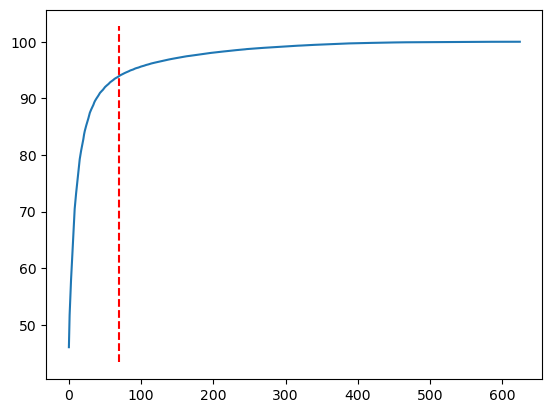

In [8]:
plt.plot(Days_Fea_Atty_df.index,Days_Fea_Atty_df['cum_perc'])
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red')
plt.show()

### 2.Survival analysis

In [9]:
# getting data for Attorney repped 
Days_Fea_Atty_AttyInd =injury_Atty[['Days_Fea_Atty', 'AttyRep']].dropna()
print(Days_Fea_Atty_AttyInd.shape)

(226170, 2)


In [10]:
# Create an object for KaplanMeierFitter
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [11]:
#fit kmf
kmf = kmf.fit(durations=Days_Fea_Atty_AttyInd['Days_Fea_Atty'], event_observed=Days_Fea_Atty_AttyInd['AttyRep'])


In [12]:
#kmf prediction
kmf.predict(7)

0.3167130919220057

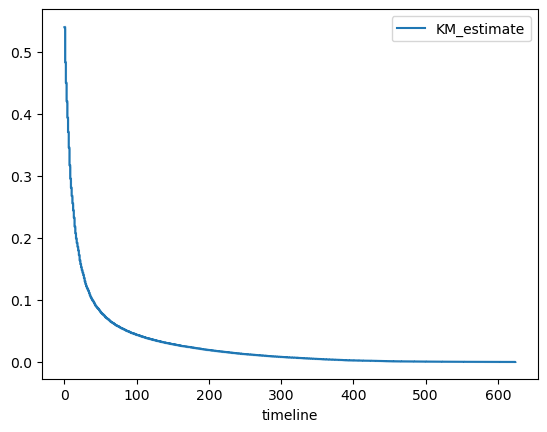

In [13]:
#plot out kmf curve
kmf.plot()
plt.show()

<AxesSubplot:xlabel='timeline'>

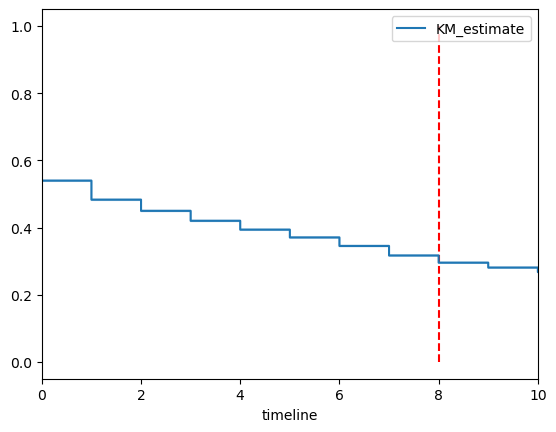

In [14]:
#kmf limited time duration
plt.xlim([0, 10])
plt.vlines(8, plt.ylim()[0], plt.ylim()[1],colors='red',linestyles='dashed')
kmf.plot()

In [15]:
kmf.event_table.head(10)

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,104160,104160,0,226170,226170
1.0,12815,12815,0,0,122010
2.0,7524,7524,0,0,109195
3.0,6696,6696,0,0,101671
4.0,5953,5953,0,0,94975
5.0,5246,5246,0,0,89022
6.0,5727,5727,0,0,83776
7.0,6418,6418,0,0,78049
8.0,4839,4839,0,0,71631
